In [1]:
#Read and dropping the first column of serial number which wouldn't be important for predicion
import pandas as pd
data = pd.read_csv(r"C:\Files\Datasets\graduate-admissions\Admission_Predict_Ver1.1.csv",encoding="utf-8-sig")
data=data.iloc[:,1:]
data.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


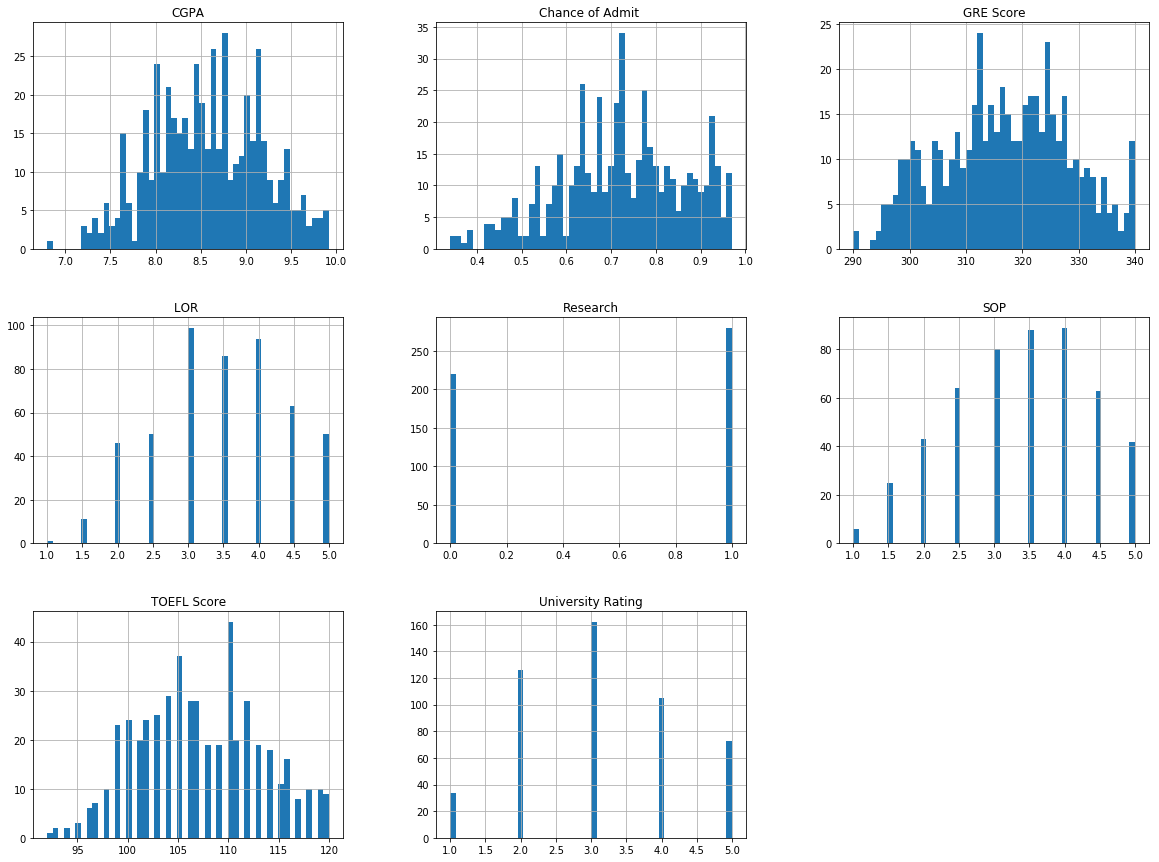

In [13]:
#Plotting histograms of all the 8 attributes/features showing the density of the spread with inline plots
%matplotlib inline
import matplotlib.pyplot as plt 
data.hist(bins=50, figsize=(20,15)) 
plt.show()

In [8]:
#Split and ignore test set until testing to avoid data snooping bias
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data, test_size=0.33, random_state=42)
#Working on a copy so as to not disturb the actual data
admission=train_set.copy()

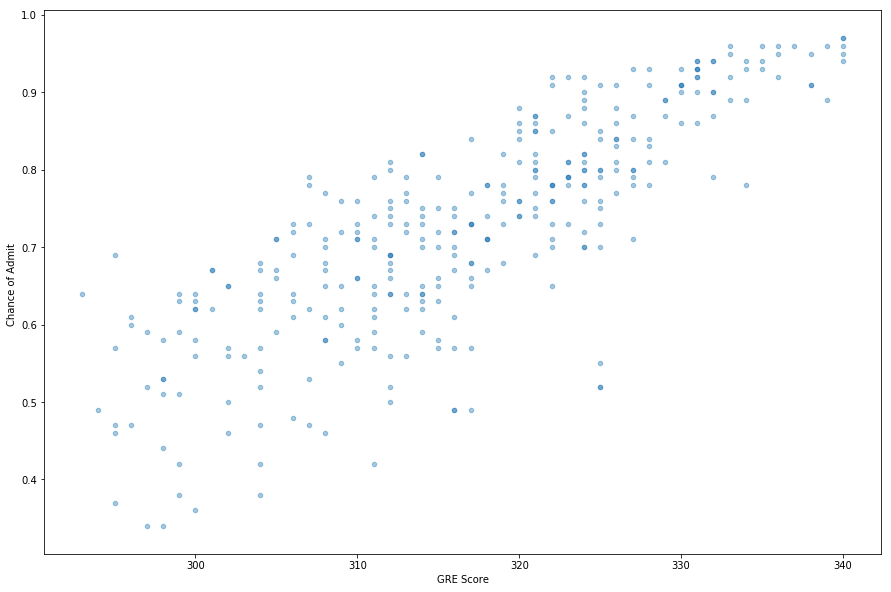

In [16]:
#Scatter plot showing the density of the instances spread
admission.plot(kind="scatter", x="GRE Score", y='Chance of Admit ',alpha=0.4,figsize=(15,10))

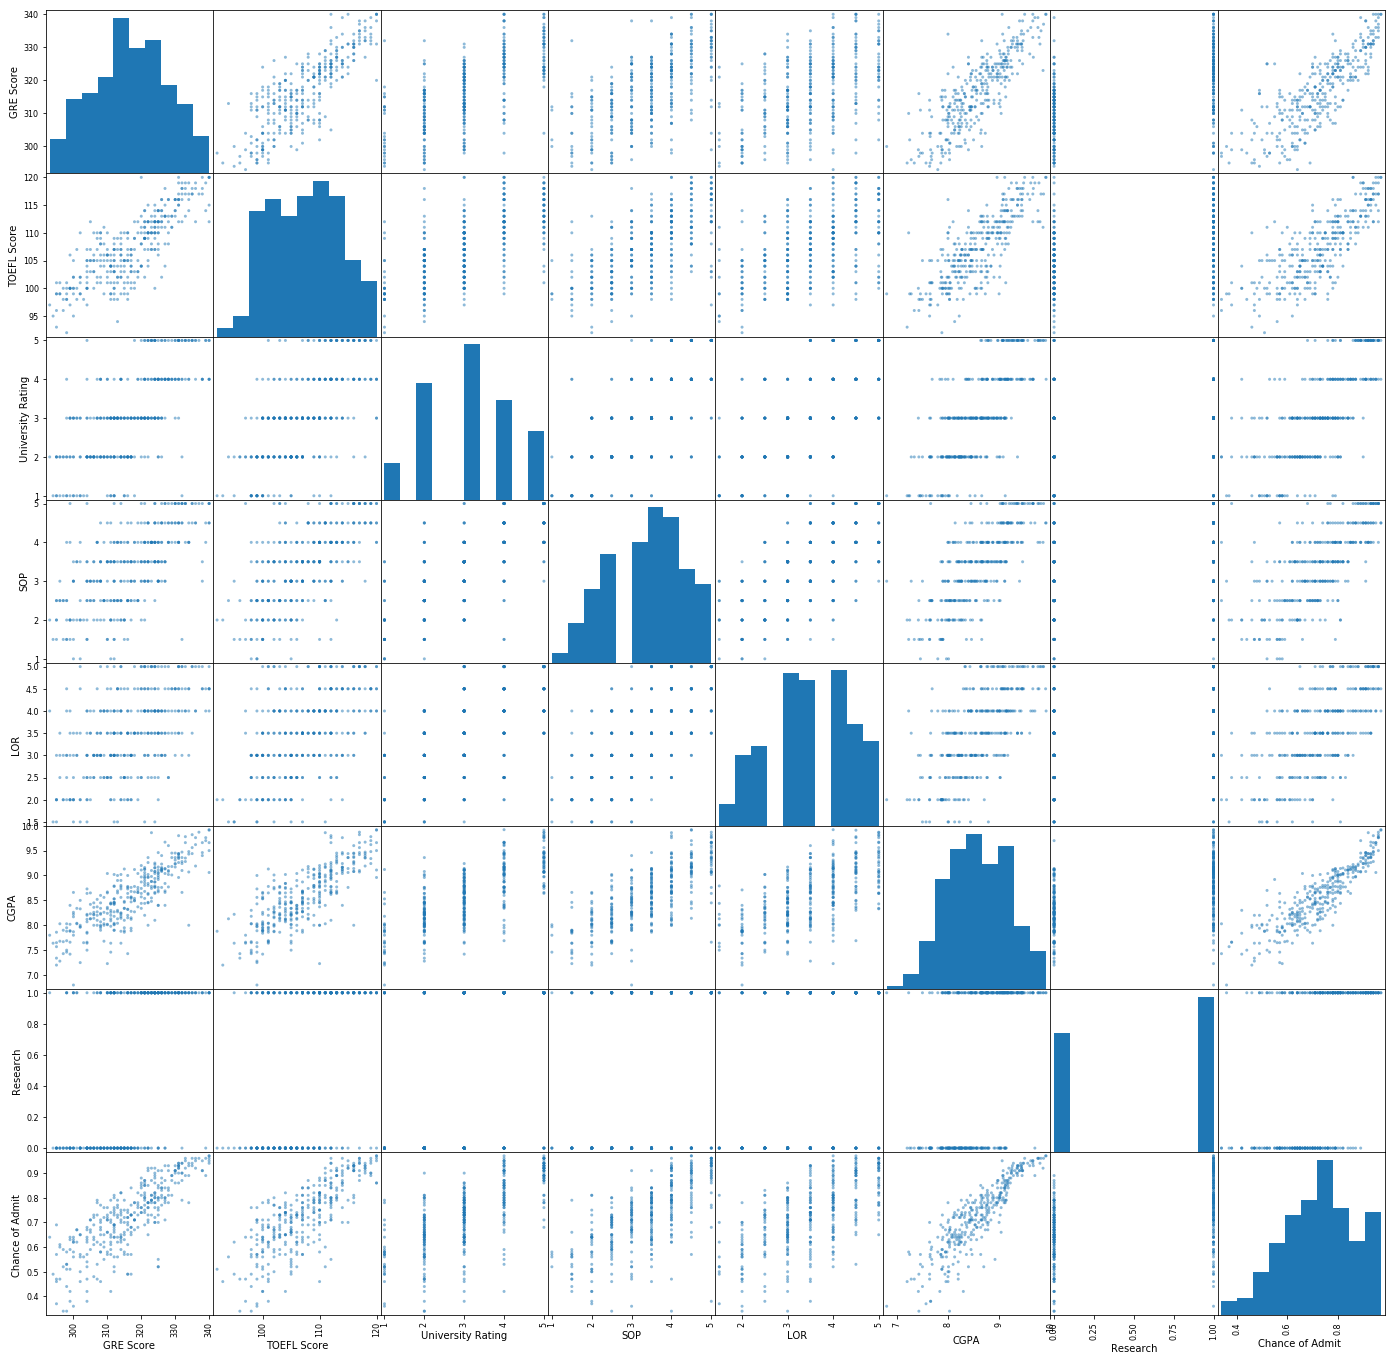

In [19]:
#Finding correlation
corr_matrix= admission.corr()
corr_matrix["GRE Score"].sort_values(ascending=False)
#plotting the correlations
from pandas.plotting import scatter_matrix
attributes = ['GRE Score','TOEFL Score','University Rating','SOP','LOR ','CGPA','Research','Chance of Admit ']
scatter_matrix(admission[attributes], figsize=(24, 24))
plt.show()

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
num_attribs = list(admission) 
num_pipeline = Pipeline([ ('selector', DataFrameSelector(num_attribs)),
                         ('imputer', Imputer(strategy="median")), 
                         ('std_scaler', StandardScaler()),
])
                
admission_prepared= num_pipeline.fit_transform(admission)
pd.DataFrame(admission_prepared).head()

,0,1,2,3,4,5,6,7
0,-0.525175,-0.706986,-0.082885,-1.385311,0.538819,-0.835766,-1.144703,-0.617241
1,0.477036,0.276434,1.652517,1.123225,-0.001613,0.363045,-1.144703,0.242831
2,-0.798505,-1.034792,-0.950586,-0.381897,0.538819,-1.156574,-1.144703,-0.330550
3,0.203706,-0.706986,-0.082885,-0.883604,0.538819,0.295507,0.873589,0.027813
4,1.297027,1.423757,1.652517,1.624933,1.619684,1.342356,0.873589,1.461266


In [29]:
admission_data =admission_prepared[:,:7]
admission_labels =admission_prepared[:,7]

In [34]:
#Using the simplest algorithm for prediction for fitting and prediction
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression() 
lin_reg.fit(admission_data,admission_labels)
admission_predictions = lin_reg.predict(admission_data)
lin_reg

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [36]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(admission_labels, admission_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.42643829043649306

In [38]:
#Now a more powerful model of Decision Tree to understand non linear relationship
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor() 
tree_reg.fit(admission_data, admission_labels)
admission_predictions = tree_reg.predict(admission_data)
tree_reg

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [39]:
#A powerful algo which moght've overfit our data with such a low rmse 
tree_mse = mean_squared_error(admission_labels, admission_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [40]:
#Now let's check using sross validation
from sklearn.model_selection import cross_val_score 
scores = cross_val_score(tree_reg, admission_data, admission_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [41]:
def display_scores(scores):
    print("Scores:", scores) 
    print("Mean:", scores.mean()) 
    print("Standard deviation:", scores.std())
display_scores(tree_rmse_scores)

Scores: [ 0.63335365  0.64995397  0.63502132  0.49151667  0.64587313  0.58039697
  0.53168502  0.54826136  0.7647458   0.7190034 ]
Mean: 0.619981128952
Standard deviation: 0.0798410737605


In [42]:
#Computing the same using lin reg
lin_scores = cross_val_score(lin_reg, admission_data, admission_labels,scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 0.5285489   0.4340748   0.41592601  0.40360598  0.46847047  0.50552952
  0.48528421  0.38962849  0.30046026  0.37235854]
Mean: 0.430388717843
Standard deviation: 0.0652653587629


In [43]:
#Same again using Random forest
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(admission_data, admission_labels)

forest_reg_scores = cross_val_score(forest_reg, admission_data, admission_labels,scoring="neg_mean_squared_error", cv=10)
forest_reg_rmse_scores = np.sqrt(-forest_reg_scores)
display_scores(forest_reg_rmse_scores)

Scores: [ 0.62068634  0.55257025  0.49918918  0.47087222  0.48624587  0.53373199
  0.4696842   0.44975876  0.57249956  0.45489683]
Mean: 0.511013520273
Standard deviation: 0.0538754748842


In [47]:
#Grid search for fine-tuning now that we found out our best performing model from the validation sets
import time
from sklearn.model_selection import GridSearchCV
param_grid = [ {'n_estimators': [3, 10, 30,50],'max_features': [2, 3, 5, 7]},#4*4=16 combinations
                {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 7]},] #2*3= 6 comnbinations
forest_reg = RandomForestRegressor()
start = time.time()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')#16+6*5=110 times training the model
grid_search.fit(admission_data, admission_labels)
print('Time elapsed: ',time.time()-start,' seconds')
grid_search.best_params_

Time elapsed:  6.139386415481567  seconds


{'max_features': 3, 'n_estimators': 30}

In [48]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [49]:
#Estimator results
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.517864712929 {'max_features': 2, 'n_estimators': 3}
0.451891263514 {'max_features': 2, 'n_estimators': 10}
0.459038718903 {'max_features': 2, 'n_estimators': 30}
0.463118327096 {'max_features': 2, 'n_estimators': 50}
0.502429697104 {'max_features': 3, 'n_estimators': 3}
0.45515810638 {'max_features': 3, 'n_estimators': 10}
0.446024199063 {'max_features': 3, 'n_estimators': 30}
0.455409902505 {'max_features': 3, 'n_estimators': 50}
0.531126557942 {'max_features': 5, 'n_estimators': 3}
0.493028169118 {'max_features': 5, 'n_estimators': 10}
0.464843034847 {'max_features': 5, 'n_estimators': 30}
0.464638539852 {'max_features': 5, 'n_estimators': 50}
0.530193842314 {'max_features': 7, 'n_estimators': 3}
0.495278870756 {'max_features': 7, 'n_estimators': 10}
0.474453734152 {'max_features': 7, 'n_estimators': 30}
0.46673481655 {'max_features': 7, 'n_estimators': 50}
0.552202949961 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
0.463621166677 {'bootstrap': False, 'max_features': 

In [50]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([ 0.22220143,  0.1430501 ,  0.06772856,  0.0491395 ,  0.03125143,
        0.46909186,  0.01753713])

In [53]:
attributes = list(train_set)
sorted(zip(feature_importances, attributes), reverse=True)

[(0.4690918578307634, 'CGPA'),
 (0.22220142844381016, 'GRE Score'),
 (0.14305010220867834, 'TOEFL Score'),
 (0.067728556485550831, 'University Rating'),
 (0.049139496857519345, 'SOP'),
 (0.031251429175096906, 'LOR '),
 (0.017537128998581016, 'Research')]

In [55]:
final_model = grid_search.best_estimator_ 
test_prepared = num_pipeline.transform(test_set) 
X_test_prepared = test_prepared[:,:7]
y_test_prepared = test_prepared[:,7]

In [57]:
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test_prepared, final_predictions) 
final_rmse = np.sqrt(final_mse)
final_rmse

0.44099475934454396